# Machine Learning Nanodegree - Capstone Project

## Who is in the photo?

The proposal of this project is to build a model that allow to recognize persons in the image using Deep Learning.

### Step 0: Import dataset

In [144]:
%matplotlib inline

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_face_dataset(path):
    data = load_files(path)
    general_targets = data['target']
    face_files = np.array(data['filenames'])
    face_targets = np_utils.to_categorical(np.array(data['target']), 16)
    return face_files, face_targets

train_files, train_targets = load_face_dataset('faces2/train')
valid_files, valid_targets = load_face_dataset('faces2/valid')
test_files, test_targets = load_face_dataset('faces2/test')

person_names = [item[12:-1] for item in sorted(glob("faces2/train/*/"))]


print('There are %d total person names.' % len(person_names))
print('There are %s total face images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training face images.' % len(train_files))
print('There are %d validation face images.' % len(valid_files))
print('There are %d test face images.'% len(test_files))

There are 16 total person names.
There are 2803 total face images.

There are 2245 training face images.
There are 277 validation face images.
There are 281 test face images.


#### Loading image data into array

In [148]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(100, 100))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

#### Loading Image for baseline model

In [149]:
import cv2
from scipy.misc import imread
from scipy.misc import imresize

def load_image_from(img_path):    
   img = cv2.imread(img_path)
#    img = cv2.resize(img,(100,100))
   return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def load_images_from(img_paths):
    images = [load_image_from(path) for path in tqdm(img_paths)]
    return np.array(images)

#### Load tensors to train, test and validations

In [150]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255



100%|██████████| 281/281 [00:00<00:00, 2775.56it/s]


#### Load image to train, test and validations of a baseline model

In [151]:
# base model
base_train_images = load_images_from(train_files).astype('float32')/255
base_test_images = load_images_from(test_files).astype('float32')/255
base_valid_images = load_images_from(valid_files).astype('float32')/255

100%|██████████| 277/277 [00:00<00:00, 4913.00it/s]


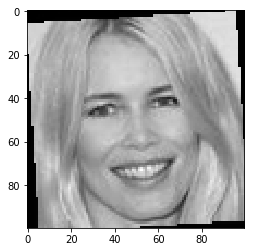

In [152]:
import matplotlib.pyplot as plt                        

img = base_train_images[0]
plt.imshow(img,cmap='gray')
plt.show()

### Step 1:  Train a base line model

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from time import time


#### Create a lookup table

In [154]:
def create_lookup_table(targets):
    lookup = []
    for target in targets:
        index = np.where(target==1)[0]
        lookup.append(index[0])
    return np.array(lookup)


In [155]:
base_train_targets = create_lookup_table(train_targets)
base_test_targets = create_lookup_table(test_targets)
base_valid_targets = create_lookup_table(valid_targets)


#### Creating a function to execute a PCA

In [191]:
def execute_pca(train, test, n_components=16):
    print("Extracting the top %d eigenfaces from %d faces"
        % (n_components, train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
            whiten=True).fit(train)

#     eigenfaces = pca.components_.T.reshape((n_components, 100, 100))

    print("done in %0.3fs" % (time() - t0))
    # eigenfaces = pca.components_.reshape((n_components, h, w))
    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(train)
    X_test_pca = pca.transform(test)
    print("done in %0.3fs" % (time() - t0))
    return X_train_pca, X_test_pca


#### Creating a function to training a model 

In [157]:
def apply_svm(X_train, y_train):
    # Train a SVM classification model
    print "Fitting the classifier to the training set"
#     param_grid = {
#     'C': [1, 5, 10, 50, 100],
#     'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
#     }
    param_grid = {
        'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
    }

    clf = GridSearchCV(SVC(kernel='rbf'), param_grid)
    clf = clf.fit(X_train, y_train)
    print "Best estimator found by grid search:"
    print clf.best_estimator_
    return clf


### Train the model

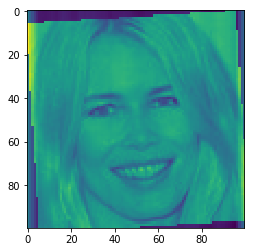

In [158]:
base_train_images -= base_train_images.mean(axis=1)[:, np.newaxis]
base_test_images -= base_test_images.mean(axis=1)[:, np.newaxis]

img = base_train_images[0]
plt.imshow(img)
plt.show()

In [159]:
X_train = base_train_images
y_train = base_train_targets

print 'NR features: %d', X_train.shape[1]

X_test  = base_test_images
y_test  = base_test_targets

X_train_pca, X_test_pca = execute_pca(X_train,X_test)
clf = apply_svm(X_train_pca, y_train)


NR features: %d 100
Extracting the top 16 eigenfaces from 2245 faces
done in 0.058s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.005s
Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=5000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### Show Results

In [160]:
y_pred = clf.predict(X_test_pca)
print classification_report(y_test, y_pred, target_names=person_names)

print confusion_matrix(y_test, y_pred, labels=range(len(person_names)))


                   precision    recall  f1-score   support

    /Adam Sandler       0.00      0.00      0.00        11
    /Alec Baldwin       0.00      0.00      0.00        10
  /Angelina Jolie       0.00      0.00      0.00        21
 /Anna Kournikova       0.00      0.00      0.00        17
  /Ashton Kutcher       0.00      0.00      0.00        10
   /Avril Lavigne       0.20      0.37      0.26        30
    /Barack Obama       0.12      0.63      0.20        27
     /Ben Affleck       0.00      0.00      0.00        12
 /Beyonce Knowles       0.00      0.00      0.00        13
       /Brad Pitt       0.19      0.17      0.18        30
    /Cameron Diaz       0.15      0.08      0.11        25
  /Cate Blanchett       0.00      0.00      0.00        16
 /Charlize Theron       0.11      0.05      0.07        20
 /Christina Ricci       0.00      0.00      0.00        14
/Claudia Schiffer       0.00      0.00      0.00        12
      /Clive Owen       0.00      0.00      0.00       

In [173]:
def image_grid(D,H,W,cols=10,scale=1, rows_count=None):
    """ display a grid of images
        H,W: Height and width of the images
        cols: number of columns = number of images in each row
        scale: 1 to fill screen
    """
    n = np.shape(D)[0]
    if rows_count:
        n = rows_count 
    rows = int(math.ceil((n+0.0)/cols))
    fig = plt.figure(1,figsize=[scale*20.0/H*W,scale*20.0/cols*rows],dpi=300)
    for i in range(n):
        plt.subplot(rows,cols,i+1)
        fig=plt.imshow(np.reshape(D[i,:],[H,W]), cmap = plt.get_cmap("gray"))
        plt.axis('off')

shape:  (100, 100)
(2245, 10000)


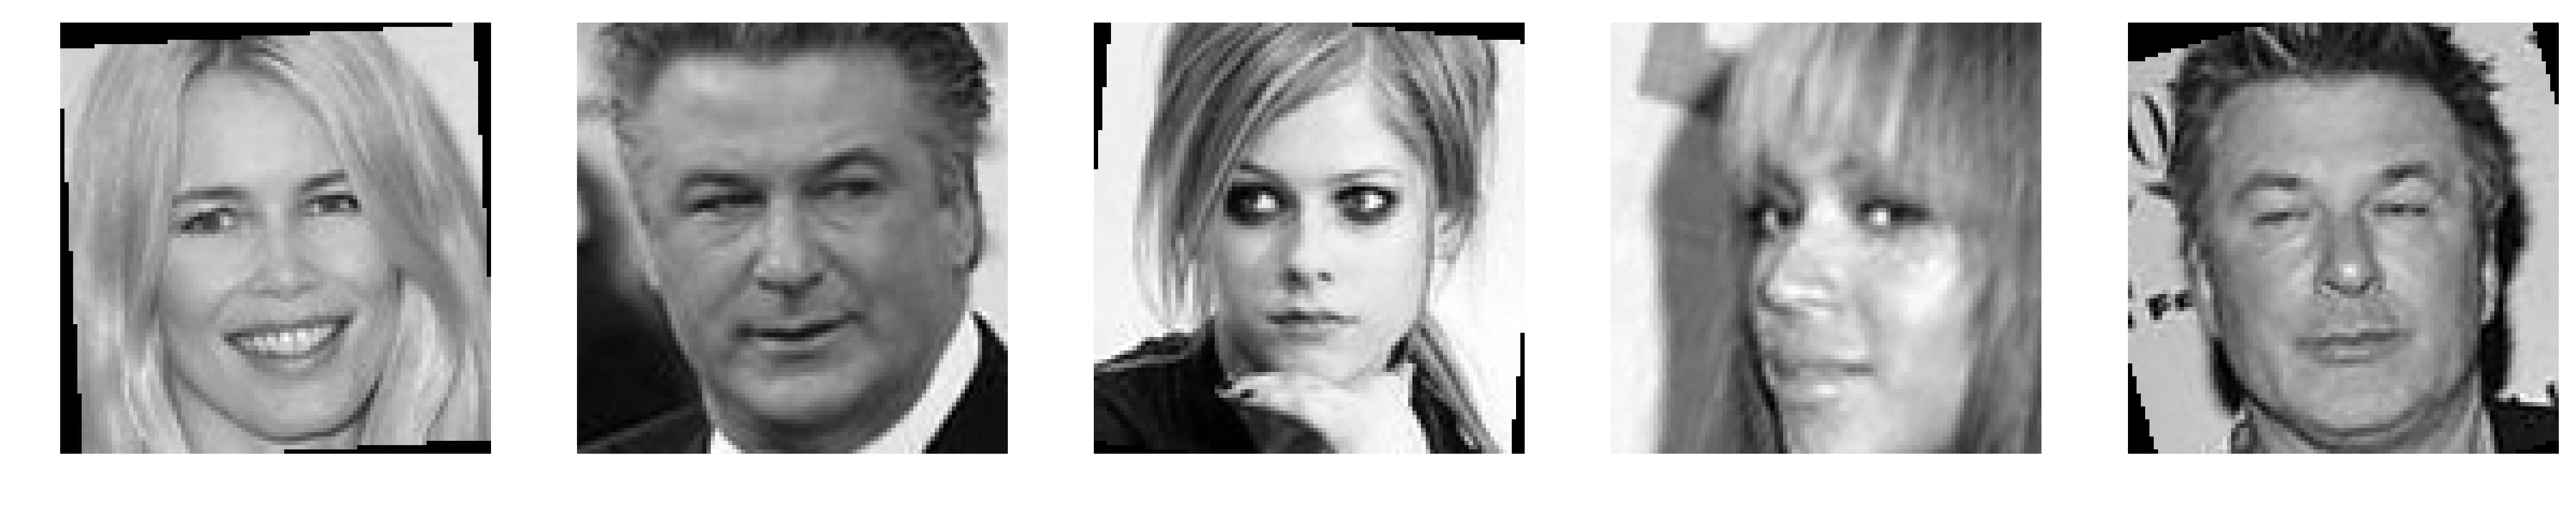

In [174]:
from PIL import Image       
import glob
import math

file_list = train_files
im = Image.open(file_list[4]).convert("L")
H,W = np.shape(im)
print 'shape: ', (H,W)

im_number = len(file_list)
# fill array with rows as image
# and columns as pixels
arr = np.zeros([im_number,H*W])
print arr.shape
for i in range(im_number):
    im = Image.open(file_list[i]).convert("L")
    arr[i,:] = np.reshape(np.asarray(im),[1,H*W])

image_grid(arr,H,W,cols=5,rows_count=5)


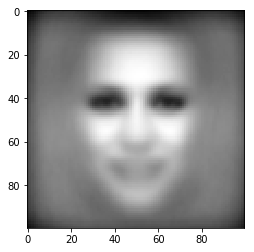

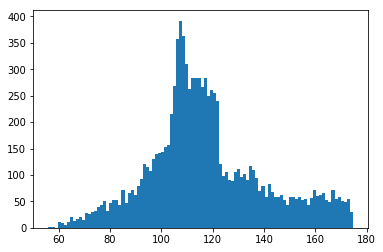

In [175]:
# let's find the mean_image
mean_image = np.mean(arr, axis=0)

plt.imshow(np.reshape(mean_image,[H,W]), cmap = plt.get_cmap("gray"))
plt.figure()
plt.hist(mean_image,bins=100);

In [176]:
# centering the data (subtract mean face)
arr_norm = np.zeros([im_number, H*W])
arr_norm = arr - mean_image

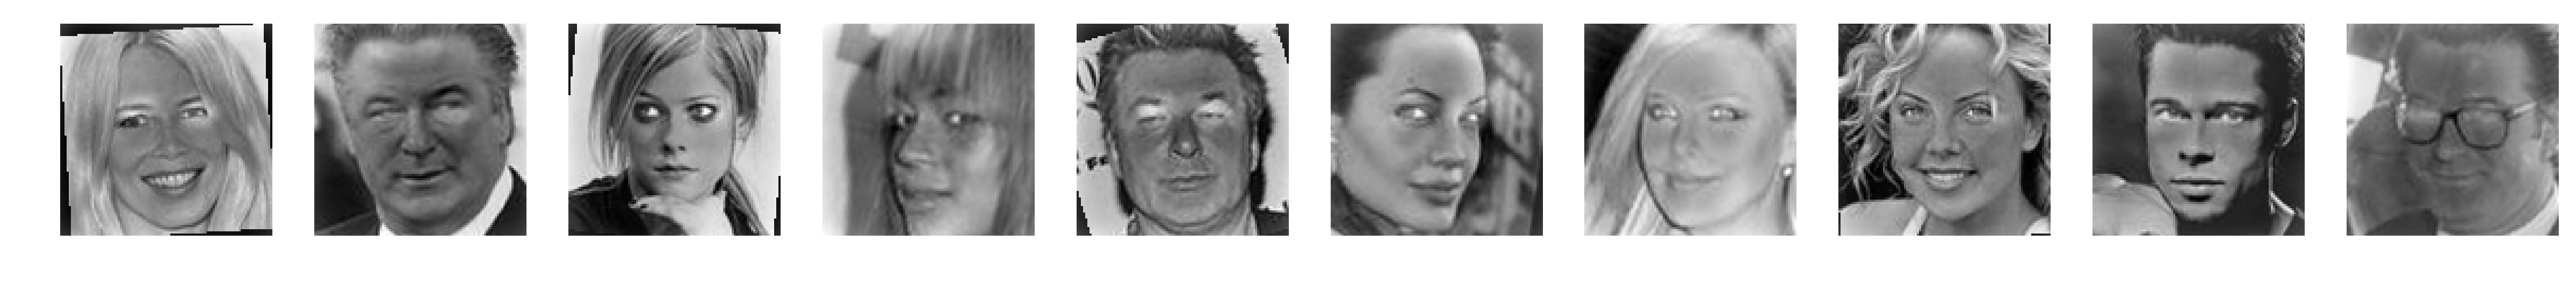

In [177]:
image_grid(arr_norm[:10,:],H,W)

In [187]:
pca = PCA(n_components=160, svd_solver='randomized')
pca.fit(arr_norm)

PCA(copy=True, iterated_power='auto', n_components=160, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

Text(0.5,0,u'Principal Component Number')

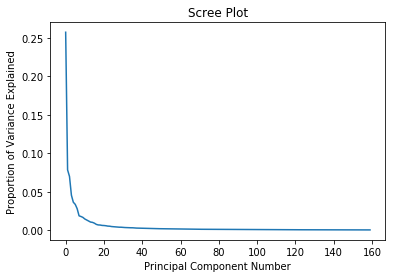

In [188]:
# Let's make a scree plot
pve = pca.explained_variance_ratio_
pve.shape
plt.plot(range(len(pve)), pve)
plt.title("Scree Plot")
plt.ylabel("Proportion of Variance Explained")
plt.xlabel("Principal Component Number")


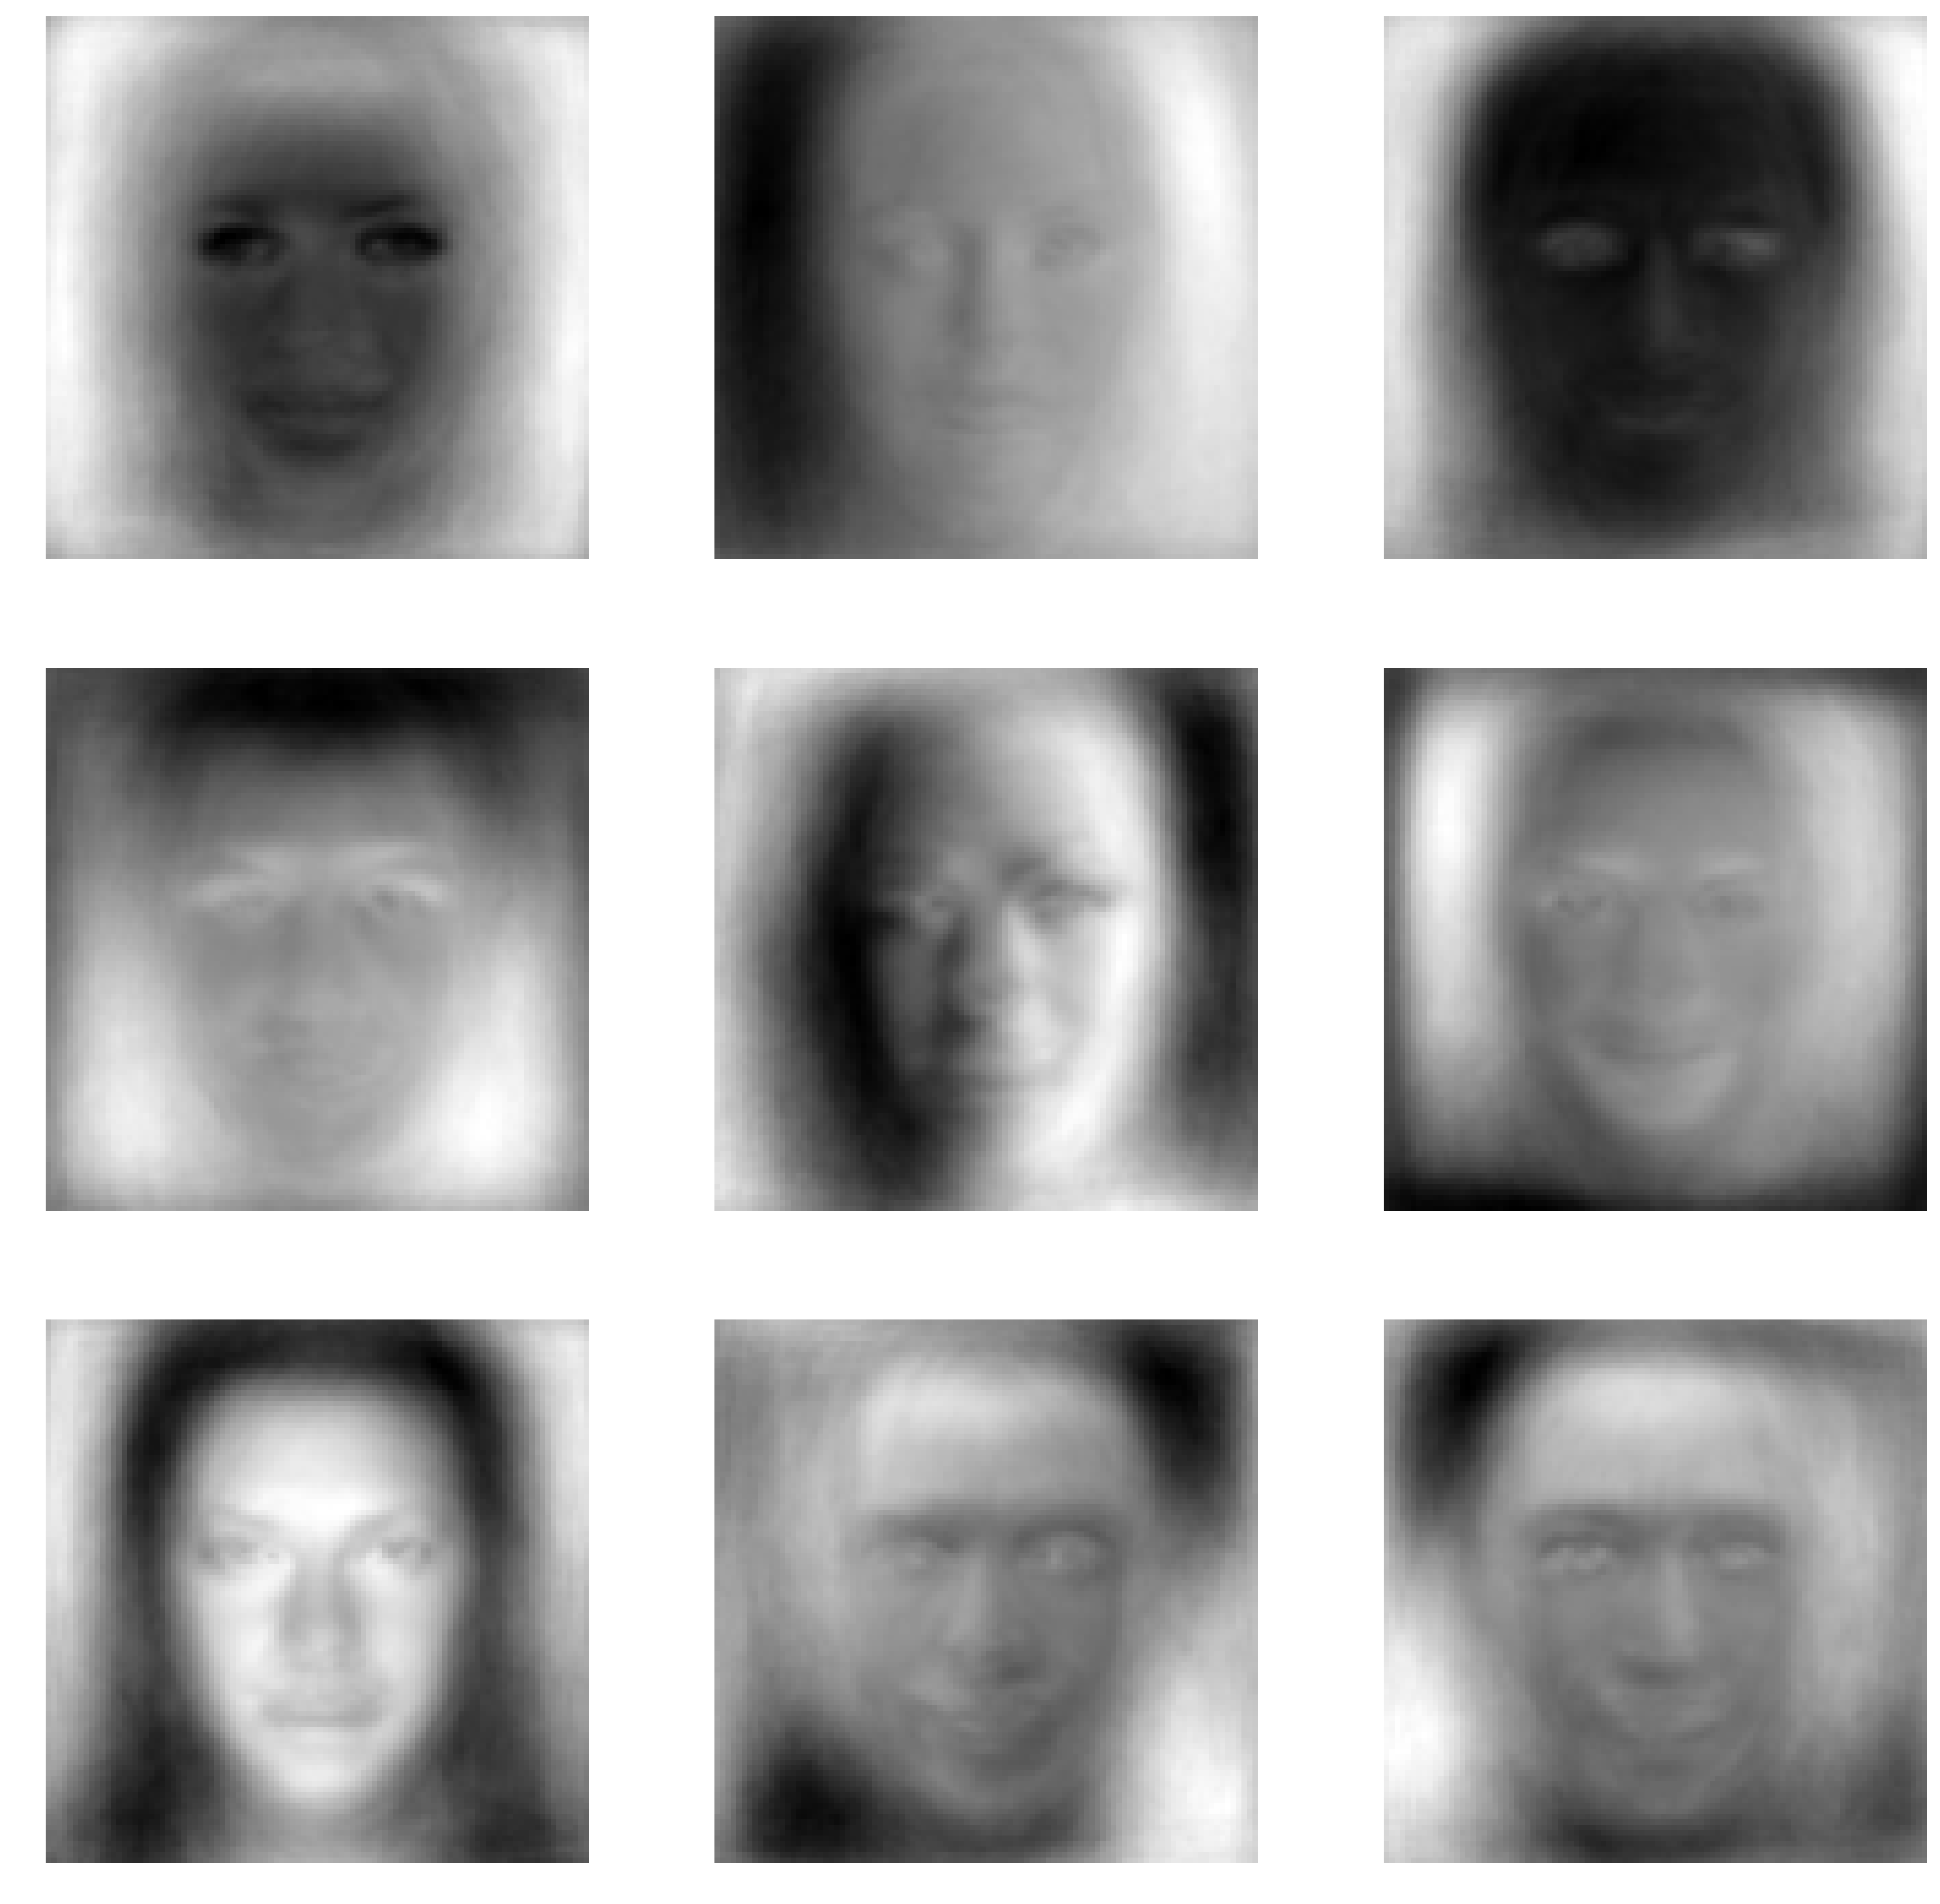

In [189]:
eigenfaces = pca.components_
image_grid(eigenfaces[:9,:], H, W, cols=3)

In [192]:
X_train_pca, X_test_pca = execute_pca(arr_norm,X_test)
clf = apply_svm(X_train_pca, y_train)


Extracting the top 16 eigenfaces from 2245 faces
done in 2.245s
Projecting the input data on the eigenfaces orthonormal basis


ValueError: Found array with dim 3. Estimator expected <= 2.

Original Images


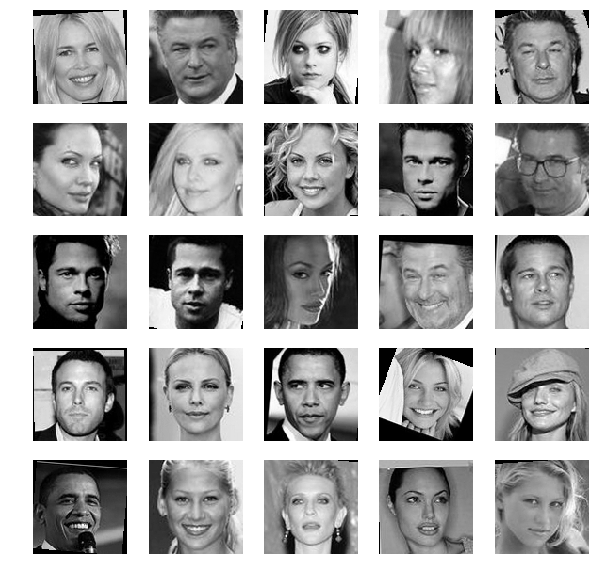

(47145, 10000)
(10000, 47145)


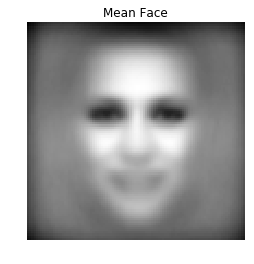

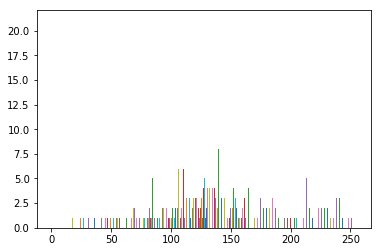